In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
from tqdm import tqdm
import shutil
import scipy.io
import logging
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split

In [ ]:
# Define paths
root_dir = "/content/drive/My Drive/HeadPose/300W_LP"
images_dir = os.path.join(root_dir, "images")
labels_dir = os.path.join(root_dir, "labels")

# Create directories if they don’t exist
os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

# Set up logging
logging.basicConfig(filename="dataset_restructure.log", level=logging.INFO, format="%(asctime)s - %(message)s")

# List dataset subfolders
subfolders = ["LFPW"]

def process_file(args):
    file, subfolder_path, images_dir, labels_dir = args
    try:
        if file.endswith((".jpg", ".png")):
            img_path = os.path.join(subfolder_path, file)
            mat_path = img_path.replace(".jpg", ".mat").replace(".png", ".mat")

            # Copy image
            new_img_path = os.path.join(images_dir, f"{os.path.basename(subfolder_path)}_{file}")
            shutil.copy(img_path, new_img_path)

            # Process .mat file
            if os.path.exists(mat_path):
                mat_data = scipy.io.loadmat(mat_path)

                if "Pose_Para" in mat_data and mat_data["Pose_Para"].size >= 3:
                    pose = mat_data["Pose_Para"].flatten()[:3]  # Extract yaw, pitch, roll
                    label_path = os.path.join(labels_dir, f"{os.path.basename(subfolder_path)}_{file.replace('.jpg', '.txt').replace('.png', '.txt')}")

                    with open(label_path, "w") as f:
                        f.write(f"{pose[0]} {pose[1]} {pose[2]}\n")

                    logging.info(f"Processed {file} successfully.")
                else:
                    logging.warning(f"Invalid 'Pose_Para' data in {mat_path}")
            else:
                logging.warning(f"No .mat file found for {file} (expected: {mat_path})")
    except Exception as e:
        logging.error(f"Error processing {file}: {e}")

def process_subfolder(subfolder):
    subfolder_path = os.path.join(root_dir, subfolder)
    files = os.listdir(subfolder_path)

    # Use multiprocessing with tqdm progress bar
    with Pool(cpu_count()) as pool, tqdm(total=len(files), desc=f"Processing {subfolder}") as pbar:
        for _ in pool.imap_unordered(process_file, [(file, subfolder_path, images_dir, labels_dir) for file in files]):
            pbar.update(1)  # Update progress bar after each processed file

# Process dataset
for subfolder in subfolders:
    logging.info(f"Processing subfolder: {subfolder}")
    process_subfolder(subfolder)

print("Dataset restructuring complete. Check 'dataset_restructure.log' for details.")

Processing LFPW: 100%|██████████| 33112/33112 [1:24:51<00:00,  6.50it/s]

Dataset restructuring complete. Check 'dataset_restructure.log' for details.


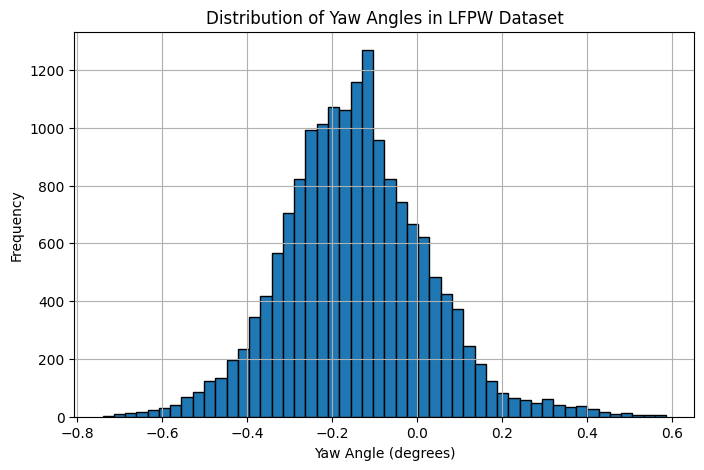

In [ ]:
# Read yaw angles from extracted .txt labels
yaw_angles = []

for label_file in os.listdir(labels_dir):
    label_path = os.path.join(labels_dir, label_file)

    with open(label_path, "r") as f:
        values = list(map(float, f.readline().split()))
        yaw = values[0]  # Extract yaw angle
        yaw_angles.append(yaw)

# Convert to numpy array
yaw_angles = np.array(yaw_angles)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(yaw_angles, bins=50, edgecolor="black")
plt.xlabel("Yaw Angle (degrees)")
plt.ylabel("Frequency")
plt.title("Distribution of Yaw Angles in LFPW Dataset")
plt.grid(True)
plt.show()

In [ ]:
# Define paths (ensure these are defined)
root_dir = "/content/drive/My Drive/HeadPose/300W_LP"
images_dir = os.path.join(root_dir, "images")
labels_dir = os.path.join(root_dir, "labels")
preprocessed_images_dir = os.path.join(root_dir, "preprocessed_images")
preprocessed_labels_dir = os.path.join(root_dir, "preprocessed_labels")

# Create directories
os.makedirs(preprocessed_images_dir, exist_ok=True)
os.makedirs(preprocessed_labels_dir, exist_ok=True)

# Normalization function for labels
def normalize_angles(yaw, pitch, roll):
    return yaw / 90.0, pitch / 90.0, roll / 90.0  # Scale to [-1,1]

# Process images and labels
for label_file in tqdm(os.listdir(labels_dir), desc="Preprocessing Dataset"):
    label_path = os.path.join(labels_dir, label_file)
    image_path = os.path.join(images_dir, label_file.replace(".txt", ".jpg"))

    if not os.path.exists(image_path):
        continue

    # Load and resize image
    try:
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Image at {image_path} could not be loaded.")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        continue

    # Normalize pixel values
    img = img.astype(np.float32) / 255.0

    # Load and normalize labels
    with open(label_path, "r") as f:
        values = list(map(float, f.readline().split()))
        if len(values) != 3:
            print(f"Warning: {label_file} does not contain three values.")
            continue
        yaw, pitch, roll = normalize_angles(*values)

    # Save preprocessed image
    new_image_path = os.path.join(preprocessed_images_dir, label_file.replace(".txt", ".npy"))
    np.save(new_image_path, img)

    # Save preprocessed labels
    new_label_path = os.path.join(preprocessed_labels_dir, label_file)
    with open(new_label_path, "w") as f:
        f.write(f"{yaw} {pitch} {roll}\n")

print("Preprocessing complete. Preprocessed dataset saved.")

Preprocessing Dataset: 100%|██████████| 16556/16556 [15:42<00:00, 17.56it/s]

Preprocessing complete. Preprocessed dataset saved.


In [ ]:
# Custom Dataset
class HeadPoseDataset(Dataset):
    def __init__(self, image_paths, label_paths):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transforms.Compose([
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = np.load(self.image_paths[idx], mmap_mode="r")
        label = np.loadtxt(self.label_paths[idx], dtype=np.float32)  # No *100!

        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)
        img = img / 255.0  # Scale to [0, 1]
        img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.float32)

# Load Data Faster
def get_file_paths(images_dir, labels_dir):
    images = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith(".npy")])
    labels = sorted([os.path.join(labels_dir, f.replace(".npy", ".txt")) for f in os.listdir(images_dir) if f.endswith(".npy")])
    return images, labels

# Paths
root_dir = "/content/drive/My Drive/HeadPose/300W_LP"
images_dir = os.path.join(root_dir, "preprocessed_images")
labels_dir = os.path.join(root_dir, "preprocessed_labels")

# Load file paths instead of full arrays
image_paths, label_paths = get_file_paths(images_dir, labels_dir)
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, label_paths, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create datasets
train_dataset = HeadPoseDataset(X_train, y_train)
val_dataset = HeadPoseDataset(X_val, y_val)
test_dataset = HeadPoseDataset(X_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

# Model Definition
class EfficientNetHeadPose(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.efficientnet_b0(weights="IMAGENET1K_V1")

        for param in self.base_model.features[:-3].parameters():  # Freeze early layers
            param.requires_grad = False

        self.base_model.classifier = nn.Sequential(
            nn.Linear(self.base_model.classifier[1].in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 3),
            nn.Tanh()
        )

    def forward(self, x):
        return self.base_model(x)

# Setup Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetHeadPose().to(device)

criterion = nn.L1Loss()  # Use MAE instead of MSE
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Training Loop
num_epochs = 20
best_val_loss = float("inf")
patience = 5
no_improvement = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Debugging: Print sample predictions and labels
        if epoch == 0 and train_loss < 1e-4:
            print("Sample predictions:", outputs[:5])
            print("Sample labels:", labels[:5])

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Step the scheduler
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_efficientnet_model.pth")
        no_improvement = 0
    else:
        no_improvement += 1

    if no_improvement >= patience:
        print("Early stopping triggered.")
        break

Epoch 1/20: 100%|██████████| 207/207 [2:46:10<00:00, 48.16s/it]


Epoch 1/20, Train Loss: 0.0078, Val Loss: 0.0020, LR: 0.001000


Epoch 2/20: 100%|██████████| 207/207 [33:56<00:00,  9.84s/it]


Epoch 2/20, Train Loss: 0.0022, Val Loss: 0.0015, LR: 0.001000


Epoch 3/20: 100%|██████████| 207/207 [44:51<00:00, 13.00s/it]


Epoch 3/20, Train Loss: 0.0019, Val Loss: 0.0014, LR: 0.001000


Epoch 4/20: 100%|██████████| 207/207 [33:48<00:00,  9.80s/it]


Epoch 4/20, Train Loss: 0.0019, Val Loss: 0.0016, LR: 0.001000


Epoch 5/20: 100%|██████████| 207/207 [33:54<00:00,  9.83s/it]


Epoch 5/20, Train Loss: 0.0018, Val Loss: 0.0015, LR: 0.001000


Epoch 6/20: 100%|██████████| 207/207 [33:46<00:00,  9.79s/it]


Epoch 6/20, Train Loss: 0.0018, Val Loss: 0.0016, LR: 0.001000


Epoch 7/20: 100%|██████████| 207/207 [33:46<00:00,  9.79s/it]



Epoch 7/20, Train Loss: 0.0017, Val Loss: 0.0016, LR: 0.001000
Epoch 7/20, Train Loss: 0.0017, Val Loss: 0.0016, LR: 0.001000


Epoch 8/20:   3%|▎         | 6/207 [00:59<33:08,  9.89s/it]



KeyboardInterrupt: 

KeyboardInterrupt: 

In [ ]:
import os
import torch

# Define the checkpoint directory and file path
checkpoint_dir = "/content/drive/My Drive/checkpoints"
checkpoint_file = "checkpoint_epoch_7.pt"
checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)

# Create the checkpoint directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# Save the current state before modifying the script
torch.save({
    'epoch': 6,  # Current epoch
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss,
}, checkpoint_path)

print(f"Checkpoint saved at {checkpoint_path}")

Checkpoint saved at /content/drive/My Drive/checkpoints/checkpoint_epoch_7.pt


In [ ]:
# Custom Dataset
class HeadPoseDataset(Dataset):
    def __init__(self, image_paths, label_paths):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transforms.Compose([
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = np.load(self.image_paths[idx], mmap_mode="r")
        label = np.loadtxt(self.label_paths[idx], dtype=np.float32)

        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)
        img = img / 255.0
        img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.float32)

# Load Data Faster
def get_file_paths(images_dir, labels_dir):
    images = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith(".npy")])
    labels = sorted([os.path.join(labels_dir, f.replace(".npy", ".txt")) for f in os.listdir(images_dir) if f.endswith(".npy")])
    return images, labels

# Paths
root_dir = "/content/drive/My Drive/HeadPose/300W_LP"
images_dir = os.path.join(root_dir, "preprocessed_images")
labels_dir = os.path.join(root_dir, "preprocessed_labels")

# Load file paths instead of full arrays
image_paths, label_paths = get_file_paths(images_dir, labels_dir)
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, label_paths, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create datasets
train_dataset = HeadPoseDataset(X_train, y_train)
val_dataset = HeadPoseDataset(X_val, y_val)
test_dataset = HeadPoseDataset(X_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

# Model Definition
class EfficientNetHeadPose(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.efficientnet_b0(weights="IMAGENET1K_V1")

        for param in self.base_model.features[:-3].parameters():
            param.requires_grad = False

        self.base_model.classifier = nn.Sequential(
            nn.Linear(self.base_model.classifier[1].in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 3),
            nn.Tanh()
        )

    def forward(self, x):
        return self.base_model(x)

# Setup Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetHeadPose().to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Checkpoint Directory
checkpoint_dir = "/content/drive/My Drive/checkpoints"
checkpoint_file = "checkpoint_epoch_7.pt"
checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)

# Load Checkpoint if Exists
start_epoch = 8
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming training from epoch {start_epoch}")

# Training Loop
num_epochs = 20
best_val_loss = float("inf")
patience = 5
no_improvement = 0

for epoch in range(start_epoch, num_epochs + 1):
    model.train()
    train_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}"):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f"Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_efficientnet_model.pth")
        no_improvement = 0
    else:
        no_improvement += 1

    if no_improvement >= patience:
        print("Early stopping triggered.")
        break

    # Save Checkpoint
    os.makedirs(checkpoint_dir, exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
    }, checkpoint_path)

    print(f"Checkpoint saved at {checkpoint_path}")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 88.1MB/s]
<ipython-input-4-767d1b4e561b>:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you do

Resuming training from epoch 7


Epoch 7/20: 100%|██████████| 207/207 [2:47:05<00:00, 48.43s/it]


Epoch 7/20, Train Loss: 0.0017, Val Loss: 0.0013, LR: 0.000500
Checkpoint saved at /content/drive/My Drive/checkpoints/checkpoint_epoch_7.pt


Epoch 8/20: 100%|██████████| 207/207 [36:31<00:00, 10.59s/it]


Epoch 8/20, Train Loss: 0.0016, Val Loss: 0.0013, LR: 0.000500
Checkpoint saved at /content/drive/My Drive/checkpoints/checkpoint_epoch_7.pt


Epoch 9/20: 100%|██████████| 207/207 [35:44<00:00, 10.36s/it]


Epoch 9/20, Train Loss: 0.0016, Val Loss: 0.0014, LR: 0.000500
Checkpoint saved at /content/drive/My Drive/checkpoints/checkpoint_epoch_7.pt


Epoch 10/20: 100%|██████████| 207/207 [38:14<00:00, 11.09s/it]


Epoch 10/20, Train Loss: 0.0016, Val Loss: 0.0013, LR: 0.000500
Checkpoint saved at /content/drive/My Drive/checkpoints/checkpoint_epoch_7.pt


Epoch 11/20: 100%|██████████| 207/207 [37:25<00:00, 10.85s/it]


Epoch 11/20, Train Loss: 0.0016, Val Loss: 0.0013, LR: 0.000500
Checkpoint saved at /content/drive/My Drive/checkpoints/checkpoint_epoch_7.pt


Epoch 12/20: 100%|██████████| 207/207 [37:20<00:00, 10.82s/it]


Epoch 12/20, Train Loss: 0.0016, Val Loss: 0.0014, LR: 0.000500
Checkpoint saved at /content/drive/My Drive/checkpoints/checkpoint_epoch_7.pt


Epoch 13/20: 100%|██████████| 207/207 [37:30<00:00, 10.87s/it]


Epoch 13/20, Train Loss: 0.0016, Val Loss: 0.0013, LR: 0.000500
Checkpoint saved at /content/drive/My Drive/checkpoints/checkpoint_epoch_7.pt


Epoch 14/20: 100%|██████████| 207/207 [36:27<00:00, 10.57s/it]


Epoch 14/20, Train Loss: 0.0016, Val Loss: 0.0013, LR: 0.000500
Checkpoint saved at /content/drive/My Drive/checkpoints/checkpoint_epoch_7.pt


Epoch 15/20: 100%|██████████| 207/207 [35:48<00:00, 10.38s/it]


Epoch 15/20, Train Loss: 0.0015, Val Loss: 0.0013, LR: 0.000500
Checkpoint saved at /content/drive/My Drive/checkpoints/checkpoint_epoch_7.pt


Epoch 16/20: 100%|██████████| 207/207 [36:13<00:00, 10.50s/it]


Epoch 16/20, Train Loss: 0.0015, Val Loss: 0.0012, LR: 0.000250
Checkpoint saved at /content/drive/My Drive/checkpoints/checkpoint_epoch_7.pt


Epoch 17/20: 100%|██████████| 207/207 [36:28<00:00, 10.57s/it]


Epoch 17/20, Train Loss: 0.0015, Val Loss: 0.0011, LR: 0.000250
Checkpoint saved at /content/drive/My Drive/checkpoints/checkpoint_epoch_7.pt


Epoch 18/20: 100%|██████████| 207/207 [36:53<00:00, 10.70s/it]


Epoch 18/20, Train Loss: 0.0015, Val Loss: 0.0012, LR: 0.000250
Checkpoint saved at /content/drive/My Drive/checkpoints/checkpoint_epoch_7.pt


Epoch 19/20: 100%|██████████| 207/207 [36:54<00:00, 10.70s/it]


Epoch 19/20, Train Loss: 0.0014, Val Loss: 0.0012, LR: 0.000250
Checkpoint saved at /content/drive/My Drive/checkpoints/checkpoint_epoch_7.pt


Epoch 20/20: 100%|██████████| 207/207 [36:16<00:00, 10.51s/it]


Epoch 20/20, Train Loss: 0.0014, Val Loss: 0.0011, LR: 0.000250
Checkpoint saved at /content/drive/My Drive/checkpoints/checkpoint_epoch_7.pt


In [ ]:
import torch

# Load the checkpoint
checkpoint_path = "/content/drive/My Drive/checkpoints/checkpoint_epoch_7.pt"  # Path to the saved checkpoint
checkpoint = torch.load(checkpoint_path)

# Restore model and optimizer states
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']

print(f"Resuming from epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}")
model.eval()  # Set the model to evaluation mode
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation
    for inputs, targets in val_loader:  # Assuming you have a validation DataLoader
        inputs, targets = inputs.to(device), targets.to(device)  # Move to device if necessary
        outputs = model(inputs)
        loss = criterion(outputs, targets)  # Compute loss
        val_loss += loss.item()

        # Compute accuracy (or other metrics)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class indices
        total += targets.size(0)

        # If targets are one-hot encoded, convert them to class indices
        if targets.dim() > 1:  # Check if targets are one-hot encoded
            targets = torch.argmax(targets, dim=1)

        correct += (predicted == targets).sum().item()

# Calculate average validation loss and accuracy
val_loss /= len(val_loader)
val_accuracy = 100 * correct / total

print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

<ipython-input-8-63c9bcb38c50>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Resuming from epoch 25, Train Loss: 0.0013913958252448103, Val Loss: 0.0010923954049268593
Validation Loss: 0.0011, Validation Accuracy: 91.61%


In [ ]:
# Custom Dataset
class HeadPoseDataset(Dataset):
    def __init__(self, image_paths, label_paths):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transforms.Compose([
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = np.load(self.image_paths[idx], mmap_mode="r")
        label = np.loadtxt(self.label_paths[idx], dtype=np.float32)

        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) / 255.0
        img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.float32)

# Load Data Paths
def get_file_paths(images_dir, labels_dir):
    images = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith(".npy")])
    labels = sorted([os.path.join(labels_dir, f.replace(".npy", ".txt")) for f in os.listdir(images_dir) if f.endswith(".npy")])
    return images, labels

# Paths
root_dir = "/content/drive/My Drive/HeadPose/300W_LP"
images_dir = os.path.join(root_dir, "preprocessed_images")
labels_dir = os.path.join(root_dir, "preprocessed_labels")

image_paths, label_paths = get_file_paths(images_dir, labels_dir)
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, label_paths, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Datasets & Loaders
train_dataset = HeadPoseDataset(X_train, y_train)
val_dataset = HeadPoseDataset(X_val, y_val)
test_dataset = HeadPoseDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

# Model
class EfficientNetHeadPose(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.efficientnet_b0(weights="IMAGENET1K_V1")

        # Unfreeze last 5 layers for better fine-tuning
        for param in self.base_model.features[:-5].parameters():
            param.requires_grad = False

        self.base_model.classifier = nn.Sequential(
            nn.Linear(self.base_model.classifier[1].in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 3),
            nn.Tanh()
        )

    def forward(self, x):
        return self.base_model(x)

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetHeadPose().to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

scaler = torch.cuda.amp.GradScaler()  # Mixed Precision Training

# Checkpoint
checkpoint_dir = "/content/drive/My Drive/checkpoints"
checkpoint_file = "checkpoint_epoch_7.pt"
checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)

start_epoch = 8
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming training from epoch {start_epoch}")

# Training Loop
num_epochs = 30
best_val_loss = float("inf")
patience = 10
no_improvement = 0
accumulation_steps = 2  # Gradient Accumulation Steps

for epoch in range(start_epoch, num_epochs + 1):
    model.train()
    train_loss = 0.0

    for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():  # Mixed Precision Training
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or i == len(train_loader) - 1:
            scaler.step(optimizer)
            scaler.update()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f"Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    scheduler.step(val_loss)

    # Save Best Model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_efficientnet_model.pth")
        no_improvement = 0
    else:
        no_improvement += 1

    # Early Stopping
    if no_improvement >= patience:
        print("Early stopping triggered.")
        break

    # Save Checkpoint
    os.makedirs(checkpoint_dir, exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
    }, checkpoint_path)

    print(f"Checkpoint saved at {checkpoint_path}")

<ipython-input-7-d38459745aba>:78: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Mixed Precision Training
<ipython-input-7-d38459745aba>:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case whe

Resuming training from epoch 21


Epoch 21/30:   0%|          | 0/207 [00:00<?, ?it/s]<ipython-input-7-d38459745aba>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed Precision Training
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 21/30: 100%|██████████| 207/207 [2:45:06<00:00, 47.86s/it]


Epoch 21/30, Train Loss: 0.0014, Val Loss: 0.0011, LR: 0.000250
Checkpoint saved at /content/drive/My Drive/checkpoints/checkpoint_epoch_7.pt


Epoch 22/30: 100%|██████████| 207/207 [44:42<00:00, 12.96s/it]


Epoch 22/30, Train Loss: 0.0014, Val Loss: 0.0011, LR: 0.000250
Checkpoint saved at /content/drive/My Drive/checkpoints/checkpoint_epoch_7.pt


Epoch 23/30: 100%|██████████| 207/207 [44:12<00:00, 12.81s/it]


Epoch 23/30, Train Loss: 0.0014, Val Loss: 0.0011, LR: 0.000250
Checkpoint saved at /content/drive/My Drive/checkpoints/checkpoint_epoch_7.pt


Epoch 24/30: 100%|██████████| 207/207 [44:56<00:00, 13.03s/it]


Epoch 24/30, Train Loss: 0.0014, Val Loss: 0.0010, LR: 0.000250
Checkpoint saved at /content/drive/My Drive/checkpoints/checkpoint_epoch_7.pt


Epoch 25/30: 100%|██████████| 207/207 [44:45<00:00, 12.97s/it]


Epoch 25/30, Train Loss: 0.0014, Val Loss: 0.0011, LR: 0.000250
Checkpoint saved at /content/drive/My Drive/checkpoints/checkpoint_epoch_7.pt


Epoch 26/30:   1%|          | 2/207 [00:39<1:07:24, 19.73s/it]


KeyboardInterrupt: 

In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm

# Load Test Data
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

# Load Best Model
model = EfficientNetHeadPose().to(device)
model.load_state_dict(torch.load("best_efficientnet_model.pth", map_location=device))
model.eval()

# Loss Metric
mae_criterion = torch.nn.L1Loss(reduction='mean')

# Testing Loop
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = model(images)

        loss = mae_criterion(outputs, labels)
        test_loss += loss.item()

        all_preds.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Compute Mean Absolute Error (MAE)
test_loss /= len(test_loader)
print(f"Test MAE Loss: {test_loss:.4f}")

# Convert Lists to Numpy Arrays
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Display Sample Predictions
for i in range(5):
    print(f"Sample {i+1}:")
    print(f"  Predicted: {all_preds[i]}")
    print(f"  Actual:    {all_labels[i]}")

<ipython-input-9-893bf351f90d>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_efficientnet_model.pth", map_location=device))
Testin

Test MAE Loss: 0.0010
Sample 1:
  Predicted: [-0.0008264   0.0039018  -0.00080449]
  Actual:    [-0.00036438  0.00432281 -0.00150956]
Sample 2:
  Predicted: [-0.00093972  0.0023889  -0.00068623]
  Actual:    [ 9.4235344e-05  1.4284389e-03 -5.4268329e-04]
Sample 3:
  Predicted: [-0.00229054 -0.01055341 -0.00016591]
  Actual:    [-0.0028685  -0.01105104  0.00109767]
Sample 4:
  Predicted: [-0.00104344 -0.00197996 -0.00050393]
  Actual:    [-0.00022078 -0.00197569  0.00056451]
Sample 5:
  Predicted: [ 0.00014675  0.00464078 -0.00066372]
  Actual:    [ 0.00055976  0.00510569 -0.00534981]


In [ ]:
import os
import torch

# Define the directory and filename
save_dir = "/content/drive/My Drive/Models"  # Example: Save to Google Drive
filename = "final_efficientnet_model.pth"

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Combine directory and filename
save_path = os.path.join(save_dir, filename)

# Save the model
torch.save(model.state_dict(), save_path)

print(f"Model saved to: {save_path}")

Model saved to: /content/drive/My Drive/Models/final_efficientnet_model.pth


In [ ]:
import os
import cv2
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error

# Define dataset class
class SynthesEyesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for subject in os.listdir(root_dir):
            subject_dir = os.path.join(root_dir, subject)
            if os.path.isdir(subject_dir):
                for file in os.listdir(subject_dir):
                    if file.endswith('.png'):
                        img_path = os.path.join(subject_dir, file)
                        gaze_path = img_path.replace('.png', '_gaze.npy')

                        if not os.path.exists(gaze_path):
                            continue

                        gaze = np.load(gaze_path)
                        self.samples.append((img_path, gaze))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, gaze = self.samples[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(gaze, dtype=torch.float32)

# Define model
class GazeNet(nn.Module):
    def __init__(self):
        super(GazeNet, self).__init__()
        self.backbone = models.efficientnet_b0(weights='DEFAULT')
        self.backbone.classifier = nn.Linear(self.backbone.classifier[1].in_features, 128)
        self.gaze_fc = nn.Linear(128, 3)

    def forward(self, x):
        features = self.backbone(x)
        gaze = self.gaze_fc(features)
        return gaze

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset_path = r"G:\My Drive\GazePose\preprocessed"
save_path = r"G:\My Drive\Models"
dataset = SynthesEyesDataset(root_dir=dataset_path, transform=transform)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Verify dataset size
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 9105
Validation samples: 2277


In [ ]:
# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GazeNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scaler = torch.amp.GradScaler(enabled=torch.cuda.is_available())
best_val_loss = float('inf')

# Training loop
num_epochs = 20
log_file = os.path.join(dataset_path, "gaze_predictions_log.txt")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, gazes in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=False):
        imgs, gazes = imgs.to(device), gazes.to(device)

        with torch.amp.autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
            pred_gaze = model(imgs)
            loss = criterion(pred_gaze, gazes)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
        running_loss += loss.item()

    scheduler.step()
    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    all_gaze_outputs, all_gaze_targets = [], []

    with open(log_file, "a") as f, torch.no_grad():
        for imgs, gazes in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            imgs, gazes = imgs.to(device), gazes.to(device)
            pred_gaze = model(imgs)
            val_loss += criterion(pred_gaze, gazes).item()
            all_gaze_outputs.append(pred_gaze.cpu().numpy())
            all_gaze_targets.append(gazes.cpu().numpy())

            for pred, actual in zip(pred_gaze.cpu().numpy(), gazes.cpu().numpy()):
                f.write(f"Predicted: {pred.tolist()}, Actual: {actual.tolist()}\n")

    all_gaze_outputs = np.concatenate(all_gaze_outputs)
    all_gaze_targets = np.concatenate(all_gaze_targets)
    gaze_mae = mean_absolute_error(all_gaze_targets, all_gaze_outputs)
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Gaze MAE: {gaze_mae:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(save_path, 'best_gaze_model.pth'))

# Save final model
torch.save(model.state_dict(), os.path.join(save_path, 'gaze_model.pth'))

Epoch [1/20], Training Loss: 0.0241


Epoch [1/20], Validation Loss: 0.0093, Gaze MAE: 0.0709


Epoch [2/20], Training Loss: 0.0061


Epoch [2/20], Validation Loss: 0.0076, Gaze MAE: 0.0669


Epoch [3/20], Training Loss: 0.0039


Epoch [3/20], Validation Loss: 0.0024, Gaze MAE: 0.0382


Epoch [4/20], Training Loss: 0.0030


Epoch [4/20], Validation Loss: 0.0027, Gaze MAE: 0.0412


Epoch [5/20], Training Loss: 0.0028


Epoch [5/20], Validation Loss: 0.0023, Gaze MAE: 0.0361


Epoch [6/20], Training Loss: 0.0014


Epoch [6/20], Validation Loss: 0.0011, Gaze MAE: 0.0257


Epoch [7/20], Training Loss: 0.0014


Epoch [7/20], Validation Loss: 0.0016, Gaze MAE: 0.0309


Epoch [8/20], Training Loss: 0.0014


Epoch [8/20], Validation Loss: 0.0014, Gaze MAE: 0.0278


Epoch [9/20], Training Loss: 0.0013


Epoch [9/20], Validation Loss: 0.0019, Gaze MAE: 0.0338


Epoch [10/20], Training Loss: 0.0014


Epoch [10/20], Validation Loss: 0.0014, Gaze MAE: 0.0272


Epoch [11/20], Training Loss: 0.0008


Epoch [11/20], Validation Loss: 0.0011, Gaze MAE: 0.0259


Epoch [12/20], Training Loss: 0.0008


Epoch [12/20], Validation Loss: 0.0008, Gaze MAE: 0.0214


Epoch [13/20], Training Loss: 0.0008


Epoch [13/20], Validation Loss: 0.0008, Gaze MAE: 0.0206


Epoch [14/20], Training Loss: 0.0007


Epoch [14/20], Validation Loss: 0.0008, Gaze MAE: 0.0217


Epoch [15/20], Training Loss: 0.0007


Epoch [15/20], Validation Loss: 0.0008, Gaze MAE: 0.0208


Epoch [16/20], Training Loss: 0.0005


Epoch [16/20], Validation Loss: 0.0006, Gaze MAE: 0.0186


Epoch [17/20], Training Loss: 0.0004


Epoch [17/20], Validation Loss: 0.0007, Gaze MAE: 0.0197


Epoch [18/20], Training Loss: 0.0005


Epoch [18/20], Validation Loss: 0.0006, Gaze MAE: 0.0179


Epoch [19/20], Training Loss: 0.0005


Epoch [19/20], Validation Loss: 0.0006, Gaze MAE: 0.0181


Epoch [20/20], Training Loss: 0.0004


Epoch [20/20], Validation Loss: 0.0006, Gaze MAE: 0.0177


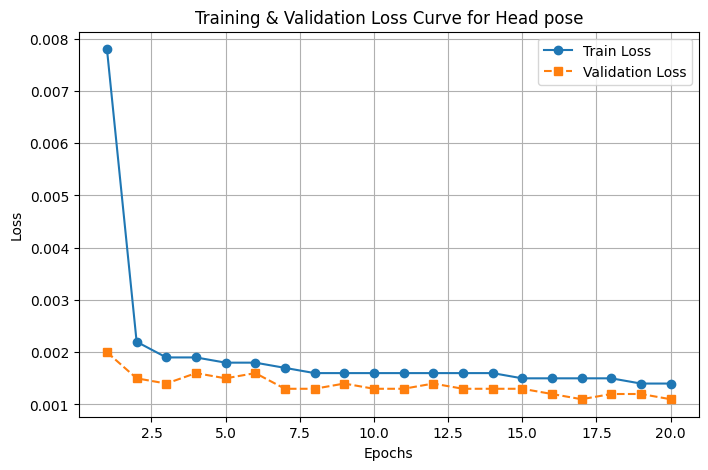

In [ ]:
import re
import matplotlib.pyplot as plt

# Sample log data (copy-paste your log content here as a multi-line string)
log_data = """
Epoch 1/20, Train Loss: 0.0078, Val Loss: 0.0020, LR: 0.001000
Epoch 2/20, Train Loss: 0.0022, Val Loss: 0.0015, LR: 0.001000
Epoch 3/20, Train Loss: 0.0019, Val Loss: 0.0014, LR: 0.001000
Epoch 4/20, Train Loss: 0.0019, Val Loss: 0.0016, LR: 0.001000
Epoch 5/20, Train Loss: 0.0018, Val Loss: 0.0015, LR: 0.001000
Epoch 6/20, Train Loss: 0.0018, Val Loss: 0.0016, LR: 0.001000
Epoch 7/20, Train Loss: 0.0017, Val Loss: 0.0013, LR: 0.000500
Epoch 8/20, Train Loss: 0.0016, Val Loss: 0.0013, LR: 0.000500
Epoch 9/20, Train Loss: 0.0016, Val Loss: 0.0014, LR: 0.000500
Epoch 10/20, Train Loss: 0.0016, Val Loss: 0.0013, LR: 0.000500
Epoch 11/20, Train Loss: 0.0016, Val Loss: 0.0013, LR: 0.000500
Epoch 12/20, Train Loss: 0.0016, Val Loss: 0.0014, LR: 0.000500
Epoch 13/20, Train Loss: 0.0016, Val Loss: 0.0013, LR: 0.000500
Epoch 14/20, Train Loss: 0.0016, Val Loss: 0.0013, LR: 0.000500
Epoch 15/20, Train Loss: 0.0015, Val Loss: 0.0013, LR: 0.000500
Epoch 16/20, Train Loss: 0.0015, Val Loss: 0.0012, LR: 0.000250
Epoch 17/20, Train Loss: 0.0015, Val Loss: 0.0011, LR: 0.000250
Epoch 18/20, Train Loss: 0.0015, Val Loss: 0.0012, LR: 0.000250
Epoch 19/20, Train Loss: 0.0014, Val Loss: 0.0012, LR: 0.000250
Epoch 20/20, Train Loss: 0.0014, Val Loss: 0.0011, LR: 0.000250
"""

# Regular expression to extract Train Loss, Val Loss, and LR
pattern = r"Epoch (\d+)/\d+, Train Loss: ([\d.]+), Val Loss: ([\d.]+), LR: ([\d.]+)"

epochs = []
train_losses = []
val_losses = []
learning_rates = []

for match in re.findall(pattern, log_data):
    epoch = int(match[0])
    train_loss = float(match[1])
    val_loss = float(match[2])
    lr = float(match[3])

    epochs.append(epoch)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    learning_rates.append(lr)

# Plot Loss Curves
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label="Train Loss", marker="o", linestyle="-")
plt.plot(epochs, val_losses, label="Validation Loss", marker="s", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve for Head pose")
plt.legend()
plt.grid()
plt.show()

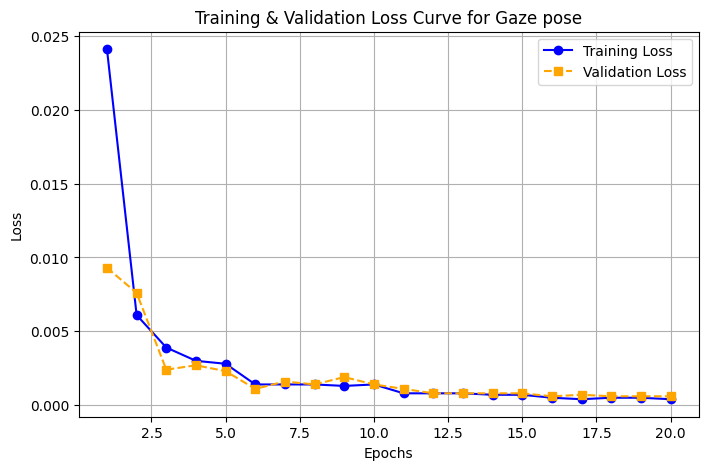

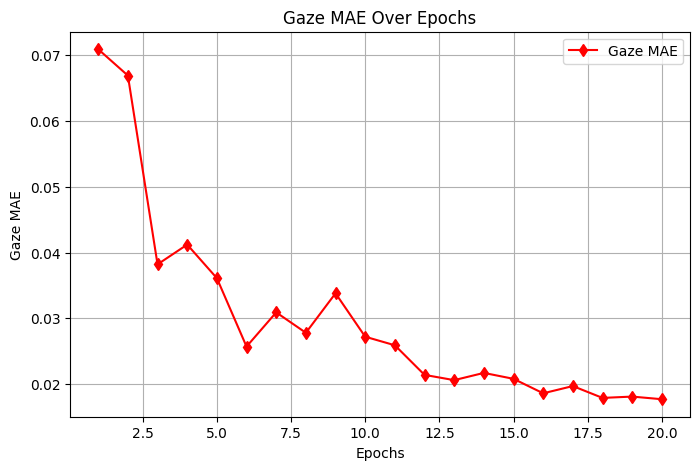

In [ ]:
import re
import matplotlib.pyplot as plt

# Sample log data (Replace this with your actual log content)
log_data = """
Epoch [1/20], Training Loss: 0.0241
Epoch [1/20], Validation Loss: 0.0093, Gaze MAE: 0.0709
Epoch [2/20], Training Loss: 0.0061
Epoch [2/20], Validation Loss: 0.0076, Gaze MAE: 0.0669
Epoch [3/20], Training Loss: 0.0039
Epoch [3/20], Validation Loss: 0.0024, Gaze MAE: 0.0382
Epoch [4/20], Training Loss: 0.0030
Epoch [4/20], Validation Loss: 0.0027, Gaze MAE: 0.0412
Epoch [5/20], Training Loss: 0.0028
Epoch [5/20], Validation Loss: 0.0023, Gaze MAE: 0.0361
Epoch [6/20], Training Loss: 0.0014
Epoch [6/20], Validation Loss: 0.0011, Gaze MAE: 0.0257
Epoch [7/20], Training Loss: 0.0014
Epoch [7/20], Validation Loss: 0.0016, Gaze MAE: 0.0309
Epoch [8/20], Training Loss: 0.0014
Epoch [8/20], Validation Loss: 0.0014, Gaze MAE: 0.0278
Epoch [9/20], Training Loss: 0.0013
Epoch [9/20], Validation Loss: 0.0019, Gaze MAE: 0.0338
Epoch [10/20], Training Loss: 0.0014
Epoch [10/20], Validation Loss: 0.0014, Gaze MAE: 0.0272
Epoch [11/20], Training Loss: 0.0008
Epoch [11/20], Validation Loss: 0.0011, Gaze MAE: 0.0259
Epoch [12/20], Training Loss: 0.0008
Epoch [12/20], Validation Loss: 0.0008, Gaze MAE: 0.0214
Epoch [13/20], Training Loss: 0.0008
Epoch [13/20], Validation Loss: 0.0008, Gaze MAE: 0.0206
Epoch [14/20], Training Loss: 0.0007
Epoch [14/20], Validation Loss: 0.0008, Gaze MAE: 0.0217
Epoch [15/20], Training Loss: 0.0007
Epoch [15/20], Validation Loss: 0.0008, Gaze MAE: 0.0208
Epoch [16/20], Training Loss: 0.0005
Epoch [16/20], Validation Loss: 0.0006, Gaze MAE: 0.0186
Epoch [17/20], Training Loss: 0.0004
Epoch [17/20], Validation Loss: 0.0007, Gaze MAE: 0.0197
Epoch [18/20], Training Loss: 0.0005
Epoch [18/20], Validation Loss: 0.0006, Gaze MAE: 0.0179
Epoch [19/20], Training Loss: 0.0005
Epoch [19/20], Validation Loss: 0.0006, Gaze MAE: 0.0181
Epoch [20/20], Training Loss: 0.0004
Epoch [20/20], Validation Loss: 0.0006, Gaze MAE: 0.0177
"""

# Regular expression to extract Training Loss, Validation Loss, and Gaze MAE
train_loss_pattern = r"Epoch \[(\d+)/\d+\], Training Loss: ([\d.]+)"
val_loss_pattern = r"Epoch \[(\d+)/\d+\], Validation Loss: ([\d.]+), Gaze MAE: ([\d.]+)"

epochs = []
train_losses = []
val_losses = []
gaze_maes = []

# Extract Training Loss
for match in re.findall(train_loss_pattern, log_data):
    epoch = int(match[0])
    train_loss = float(match[1])
    epochs.append(epoch)
    train_losses.append(train_loss)

# Extract Validation Loss & Gaze MAE
for match in re.findall(val_loss_pattern, log_data):
    val_loss = float(match[1])
    gaze_mae = float(match[2])
    val_losses.append(val_loss)
    gaze_maes.append(gaze_mae)

# Plot Loss Curves
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label="Training Loss", marker="o", linestyle="-", color="blue")
plt.plot(epochs, val_losses, label="Validation Loss", marker="s", linestyle="--", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve for Gaze pose")
plt.legend()
plt.grid()
plt.show()

# Plot Loss Curves
plt.figure(figsize=(8, 5))
plt.plot(epochs, gaze_maes, label="Gaze MAE", marker="d", linestyle="-", color="red")
plt.xlabel("Epochs")
plt.ylabel("Gaze MAE")
plt.title("Gaze MAE Over Epochs")
plt.legend()
plt.grid()
plt.show()